# Concatenation, Analysis

In [1]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
path1 = '../../../data/'

def evaluate_channel(channel, inputs, targets):
    d = channel.d
    N = inputs[0].shape[0]
    kl_div = KLDiv()
    loss = kl_div(channel, inputs, targets)/N
    return np.real(loss)


def calculate_channel_fittness(model_name, data_name, num_layers = None):
    model_list = loader("data/" + model_name)
    reps = len(model_list)//3
    
    d = model_list[0].channel.d
    n = int(np.log2(d))

    U1_circuit_list = []
    U2_circuit_list = []
    U3_circuit_list = []

    R1_fid_list = []
    R2_fid_list = []
    R3_fid_list = []

    U1_fid_list = []
    U2_fid_list = []
    U3_fid_list = []

    T1_fid_list = []
    T2_fid_list = []
    T12_fid_list = []
    T3_fid_list = []

    np.random.seed(42)
    random.seed(42)
    
    for i in tqdm(range(reps)):

        circuit1 = pqc_basic(n, num_layers)#.reverse_bits()
        U1 = circuit_to_matrix(circuit1)
        U1_circuit_list.append(U1)

        circuit2 = pqc_basic(n, num_layers)#.reverse_bits()
        U2 = circuit_to_matrix(circuit2)
        U2_circuit_list.append(U2)

        circuit3 = deepcopy(circuit1)
        circuit3 = circuit3.compose(circuit2)
        U3 = circuit_to_matrix(circuit3)
        U3_circuit_list.append(U3)

        #Throw-away computation to advance RNG correctly
        circuit_target_list = [circuit1, circuit2, circuit3]
        belem_concatenate = ExecuteAndCollect()
        belem_concatenate.setup_circuits(circuit_target_list, N_map = 2000-6**n)
    
    for i in range(reps):
        inputs1, targets1, _, _ = loader(path1 + data_name + f"{i}0")
        inputs2, targets2, _, _ = loader(path1 + data_name + f"{i}1")
        inputs3, targets3, _, _ = loader(path1 + data_name + f"{i}2")
        

        model1 = model_list[3*i]
        model2 = model_list[3*i+1]
        model3 = model_list[3*i+2]

        channel1 = model1.channel
        channel2 = model2.channel
        channel3 = model3.channel

        channel12 = channel_to_choi_map([channel1, channel2])
        channel12.spam = channel3.spam

        identity_channel1 = IdentityChannel(d)
        identity_channel1.spam = channel1.spam

        identity_channel2 = IdentityChannel(d)
        identity_channel2.spam = channel2.spam

        identity_channel3 = IdentityChannel(d)
        identity_channel3.spam = channel3.spam

        U_channel1 = ChoiMapStatic(U1_circuit_list[i], mode="unitary")
        U_channel1.spam = channel1.spam

        U_channel2 = ChoiMapStatic(U2_circuit_list[i], mode="unitary")
        U_channel2.spam = channel2.spam

        U_channel3 = ChoiMapStatic(U3_circuit_list[i], mode="unitary")
        U_channel3.spam = channel3.spam

        R1_fid_list.append(evaluate_channel(identity_channel1, inputs1, targets1))
        R2_fid_list.append(evaluate_channel(identity_channel2, inputs2, targets2))
        R3_fid_list.append(evaluate_channel(identity_channel3, inputs3, targets3)) 

        U1_fid_list.append(evaluate_channel(U_channel1, inputs1, targets1))
        U2_fid_list.append(evaluate_channel(U_channel2, inputs2, targets2))
        U3_fid_list.append(evaluate_channel(U_channel3, inputs3, targets3))

        T1_fid_list.append(evaluate_channel(channel1, inputs1, targets1))
        T2_fid_list.append(evaluate_channel(channel2, inputs2, targets2))
        T12_fid_list.append(evaluate_channel(channel12, inputs3, targets3))
        T3_fid_list.append(evaluate_channel(channel3, inputs3, targets3))
        
    
    Id_single_fid_mean = np.mean(R1_fid_list + R2_fid_list)
    Id_single_fid_std= np.std(R1_fid_list + R2_fid_list)
    
    Id_full_fid_mean = np.mean(R3_fid_list)  
    Id_full_fid_std = np.std(R3_fid_list)  

    U_single_fid_mean = np.mean(U1_fid_list + U2_fid_list)
    U_single_fid_std = np.std(U1_fid_list + U2_fid_list)
    
    U_full_fid_mean = np.mean(U3_fid_list)  
    U_full_fid_std = np.std(U3_fid_list)  
    
    T_single_fid_mean = np.mean(T1_fid_list + T2_fid_list)
    T_single_fid_std = np.std(T1_fid_list + T2_fid_list)
    
    T_concat_fid_mean = np.mean(T12_fid_list)
    T_concat_fid_std = np.std(T12_fid_list)
    
    T_full_fid_mean = np.mean(T3_fid_list)
    T_full_fid_std = np.std(T3_fid_list)
    
    mean_list = [Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean]
    std_list = [Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std]

    
    return mean_list, std_list

## KL Divergence with Respect to Real Data

In [3]:
mean_list1, std_list1 = calculate_channel_fittness(model_name="belem_concatenate_2layer_fitted.model",
                                                   data_name= "belem_concatenate_2layer", 
                                                   num_layers = 2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list1
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list1

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 1.085 +-0.093
Id Full KL-Div: 1.054 +-0.081
----
U Single KL-Div: 0.128 +-0.015
U Full KL-Div: 0.148 +-0.014
----
T Single KL-Div: 0.0085 +-0.0058
T Full KL-Div: 0.0059 +-0.0004
T Concat KL-Div: 0.053 +-0.011


In [21]:
mean_list2, std_list2 = calculate_channel_fittness(model_name="belem_concatenate_4layer_fitted.model",
                                                   data_name= "belem_concatenate_4layer", 
                                                   num_layers = 4)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list2
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list2

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 1.087 +-0.130
Id Full KL-Div: 1.008 +-0.046
----
U Single KL-Div: 0.137 +-0.030
U Full KL-Div: 0.152 +-0.016
----
T Single KL-Div: 0.0084 +-0.0091
T Full KL-Div: 0.0051 +-0.0003
T Concat KL-Div: 0.047 +-0.013


In [23]:
mean_list3, std_list3 = calculate_channel_fittness(model_name="belem_concatenate_6layer_fitted.model",
                                                   data_name= "belem_concatenate_6layer_retry", 
                                                   num_layers = 6)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list3
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list3

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 0.950 +-0.044
Id Full KL-Div: 0.908 +-0.048
----
U Single KL-Div: 0.210 +-0.022
U Full KL-Div: 0.271 +-0.022
----
T Single KL-Div: 0.0086 +-0.0080
T Full KL-Div: 0.0041 +-0.0008
T Concat KL-Div: 0.015 +-0.003


In [25]:
mean_list4, std_list4 = calculate_channel_fittness(model_name="belem_concatenate_8layer_fitted.model",
                                                   data_name= "belem_concatenate_8layer", 
                                                   num_layers = 8)

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list4
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list4

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 1.026 +-0.042
Id Full KL-Div: 0.958 +-0.054
----
U Single KL-Div: 0.158 +-0.016
U Full KL-Div: 0.214 +-0.017
----
T Single KL-Div: 0.0060 +-0.0042
T Full KL-Div: 0.0073 +-0.0103
T Concat KL-Div: 0.029 +-0.011


In [27]:
mean_list = np.array([mean_list1, mean_list2, mean_list3, mean_list4])
std_list = np.array([std_list1, std_list2, std_list3, std_list4])

In [28]:
np.savetxt("data/concatenation_highRankModel_meanKLDiv.txt", mean_list, fmt='%f')
np.savetxt("data/concatenation_highRankModel_stdKLDiv.txt", std_list, fmt='%f')

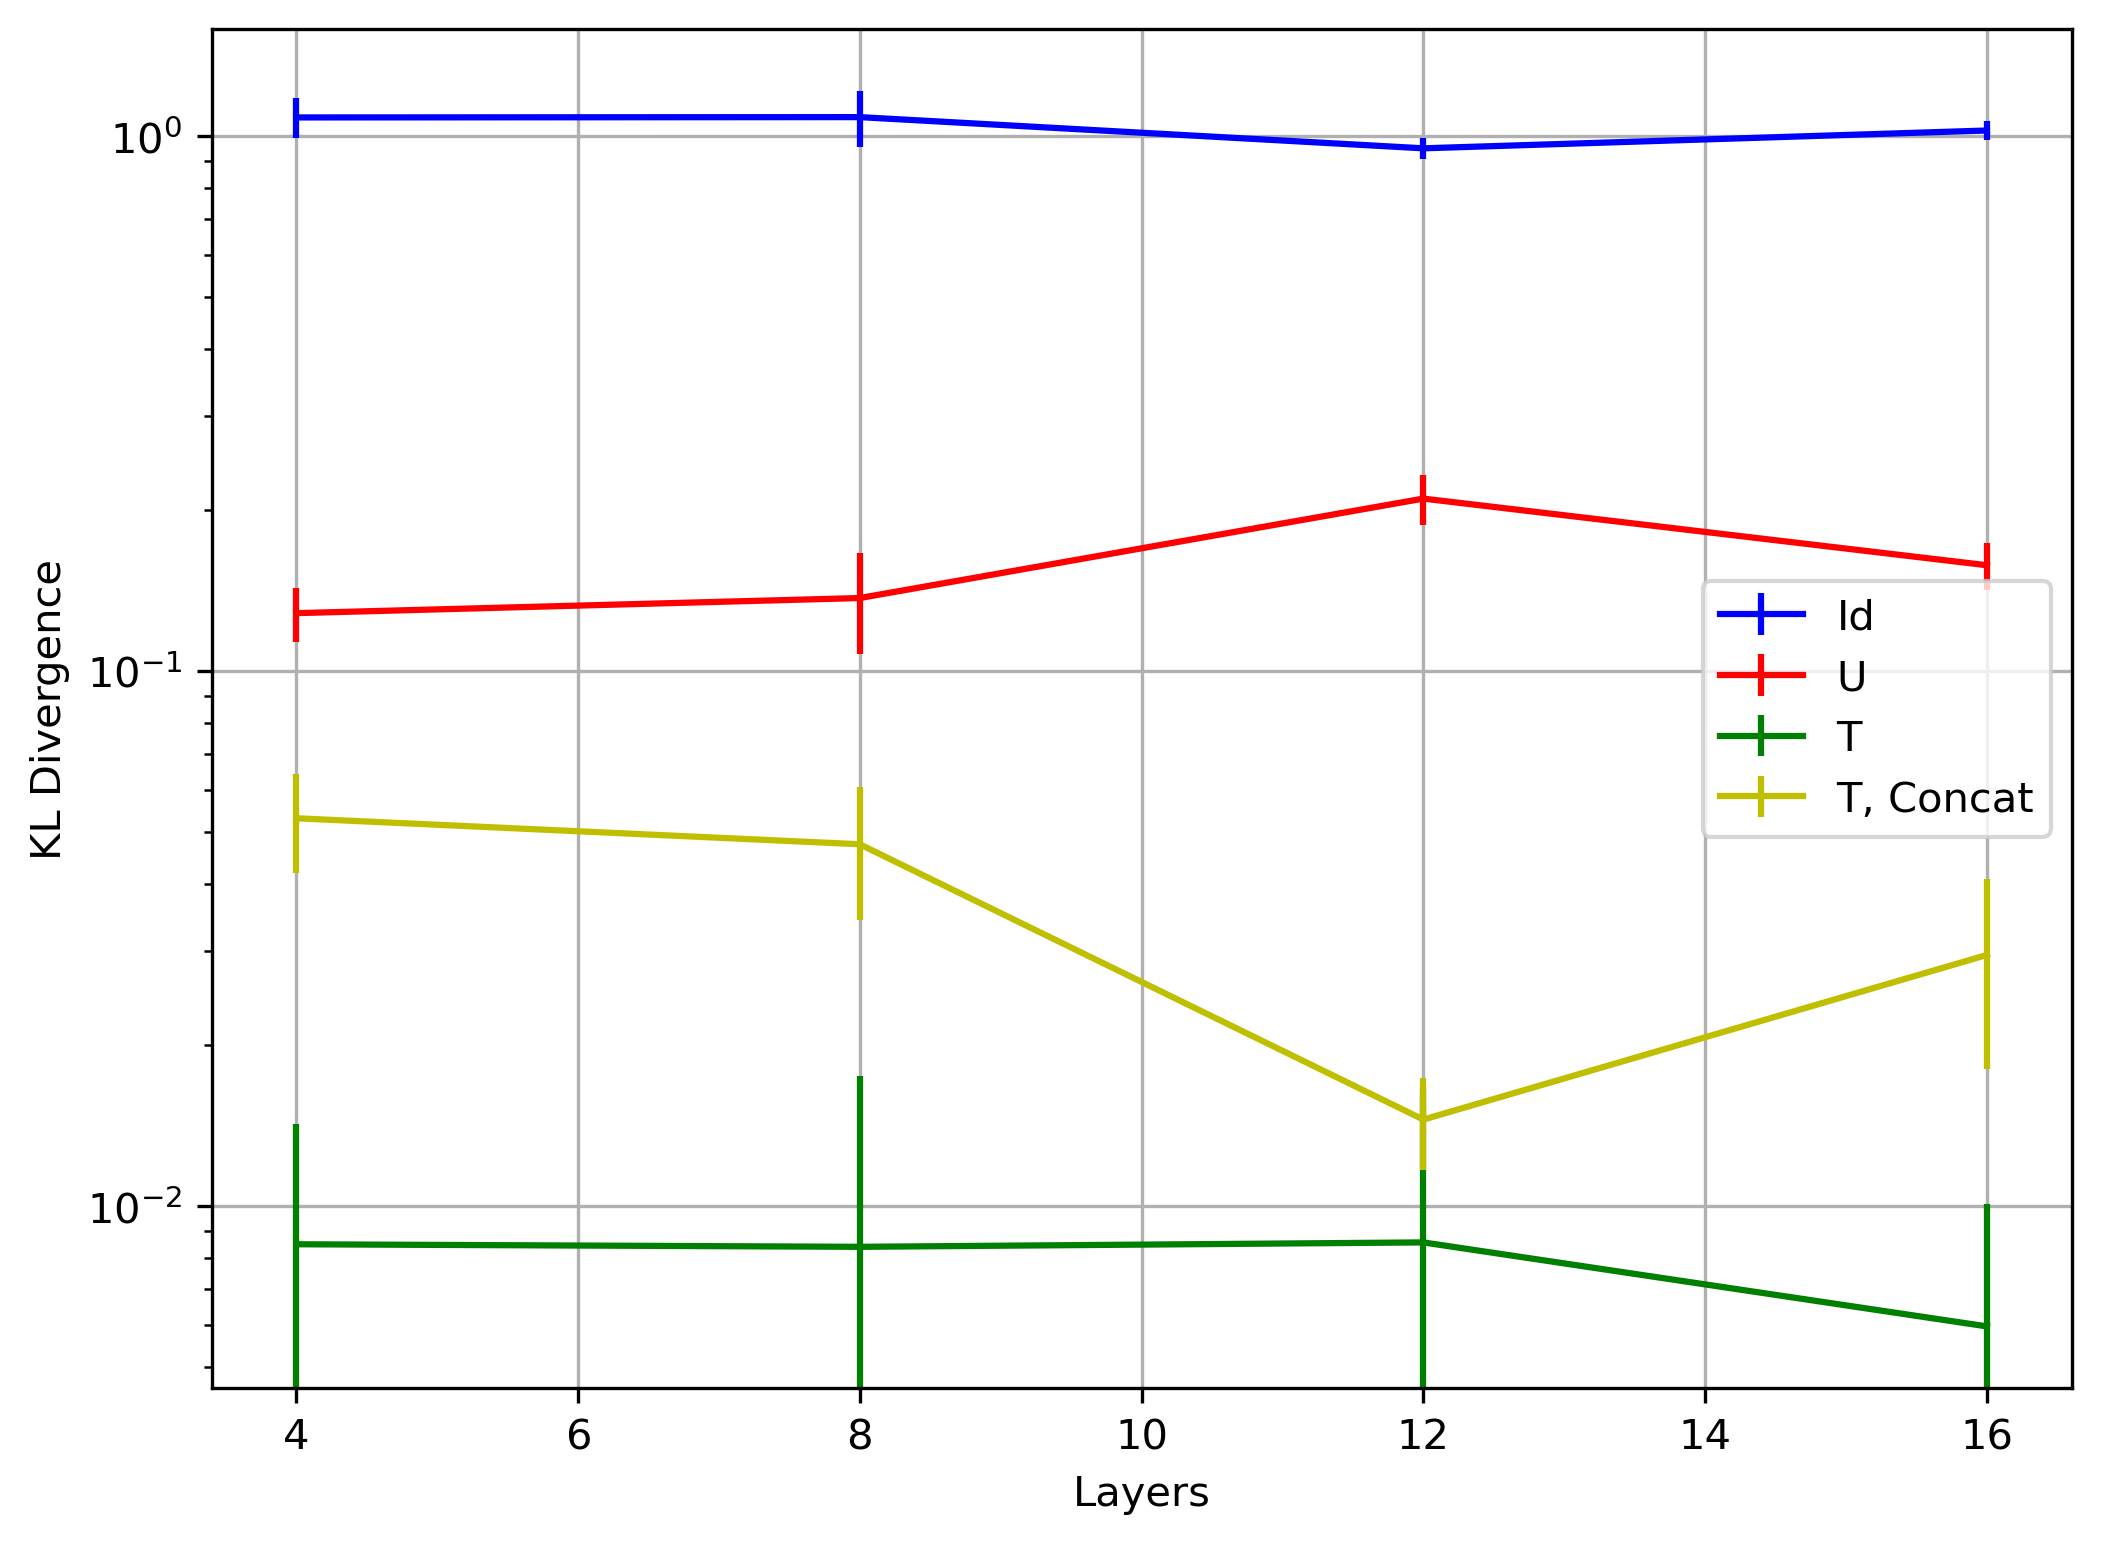

In [29]:
x = [4, 8, 12, 16]
fig = plt.figure(figsize=(8,6), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, mean_list[:,0], yerr = std_list[:,0], fmt = "b-")
plt.errorbar(x, mean_list[:,2], yerr = std_list[:,2], fmt = "r-")
plt.errorbar(x, mean_list[:,4], yerr = std_list[:,4], fmt = "g-")
plt.errorbar(x, mean_list[:,6], yerr = std_list[:,6], fmt = "y")
plt.legend(["Id", "U", "T", "T, Concat"])
plt.yscale("log")
plt.xlabel("Layers")
#plt.ylim([1e-6, 1e-3])
plt.ylabel("KL Divergence")
plt.grid()
plt.savefig("figures/concatenation_highRankModel.pdf")
plt.show()

## Unitary Models

In [20]:
mean_list5, std_list5 = calculate_channel_fittness(model_name="belem_concatenate_2layer_unitary_fitted.model",
                                                   data_name= "belem_concatenate_2layer", 
                                                   num_layers = 2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
mean_list6, std_list6 = calculate_channel_fittness(model_name="belem_concatenate_4layer_unitary_fitted.model",
                                                   data_name= "belem_concatenate_4layer", 
                                                   num_layers = 4)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
mean_list7, std_list7 = calculate_channel_fittness(model_name="belem_concatenate_6layer_unitary_fitted.model",
                                                   data_name= "belem_concatenate_6layer", 
                                                   num_layers = 6)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
mean_list8, std_list8 = calculate_channel_fittness(model_name="belem_concatenate_8layer_unitary_fitted.model",
                                                   data_name= "belem_concatenate_8layer", 
                                                   num_layers = 8)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
mean_list = np.array([mean_list5, mean_list6, mean_list7, mean_list8])
std_list = np.array([std_list5, std_list6, std_list7, std_list8])

In [25]:
np.savetxt(data_path("concatenation_unitaryModel_meanKLDiv.txt"), mean_list, fmt='%f')
np.savetxt(data_path("concatenation_unitaryModel_stdKLDiv.txt"), std_list, fmt='%f')

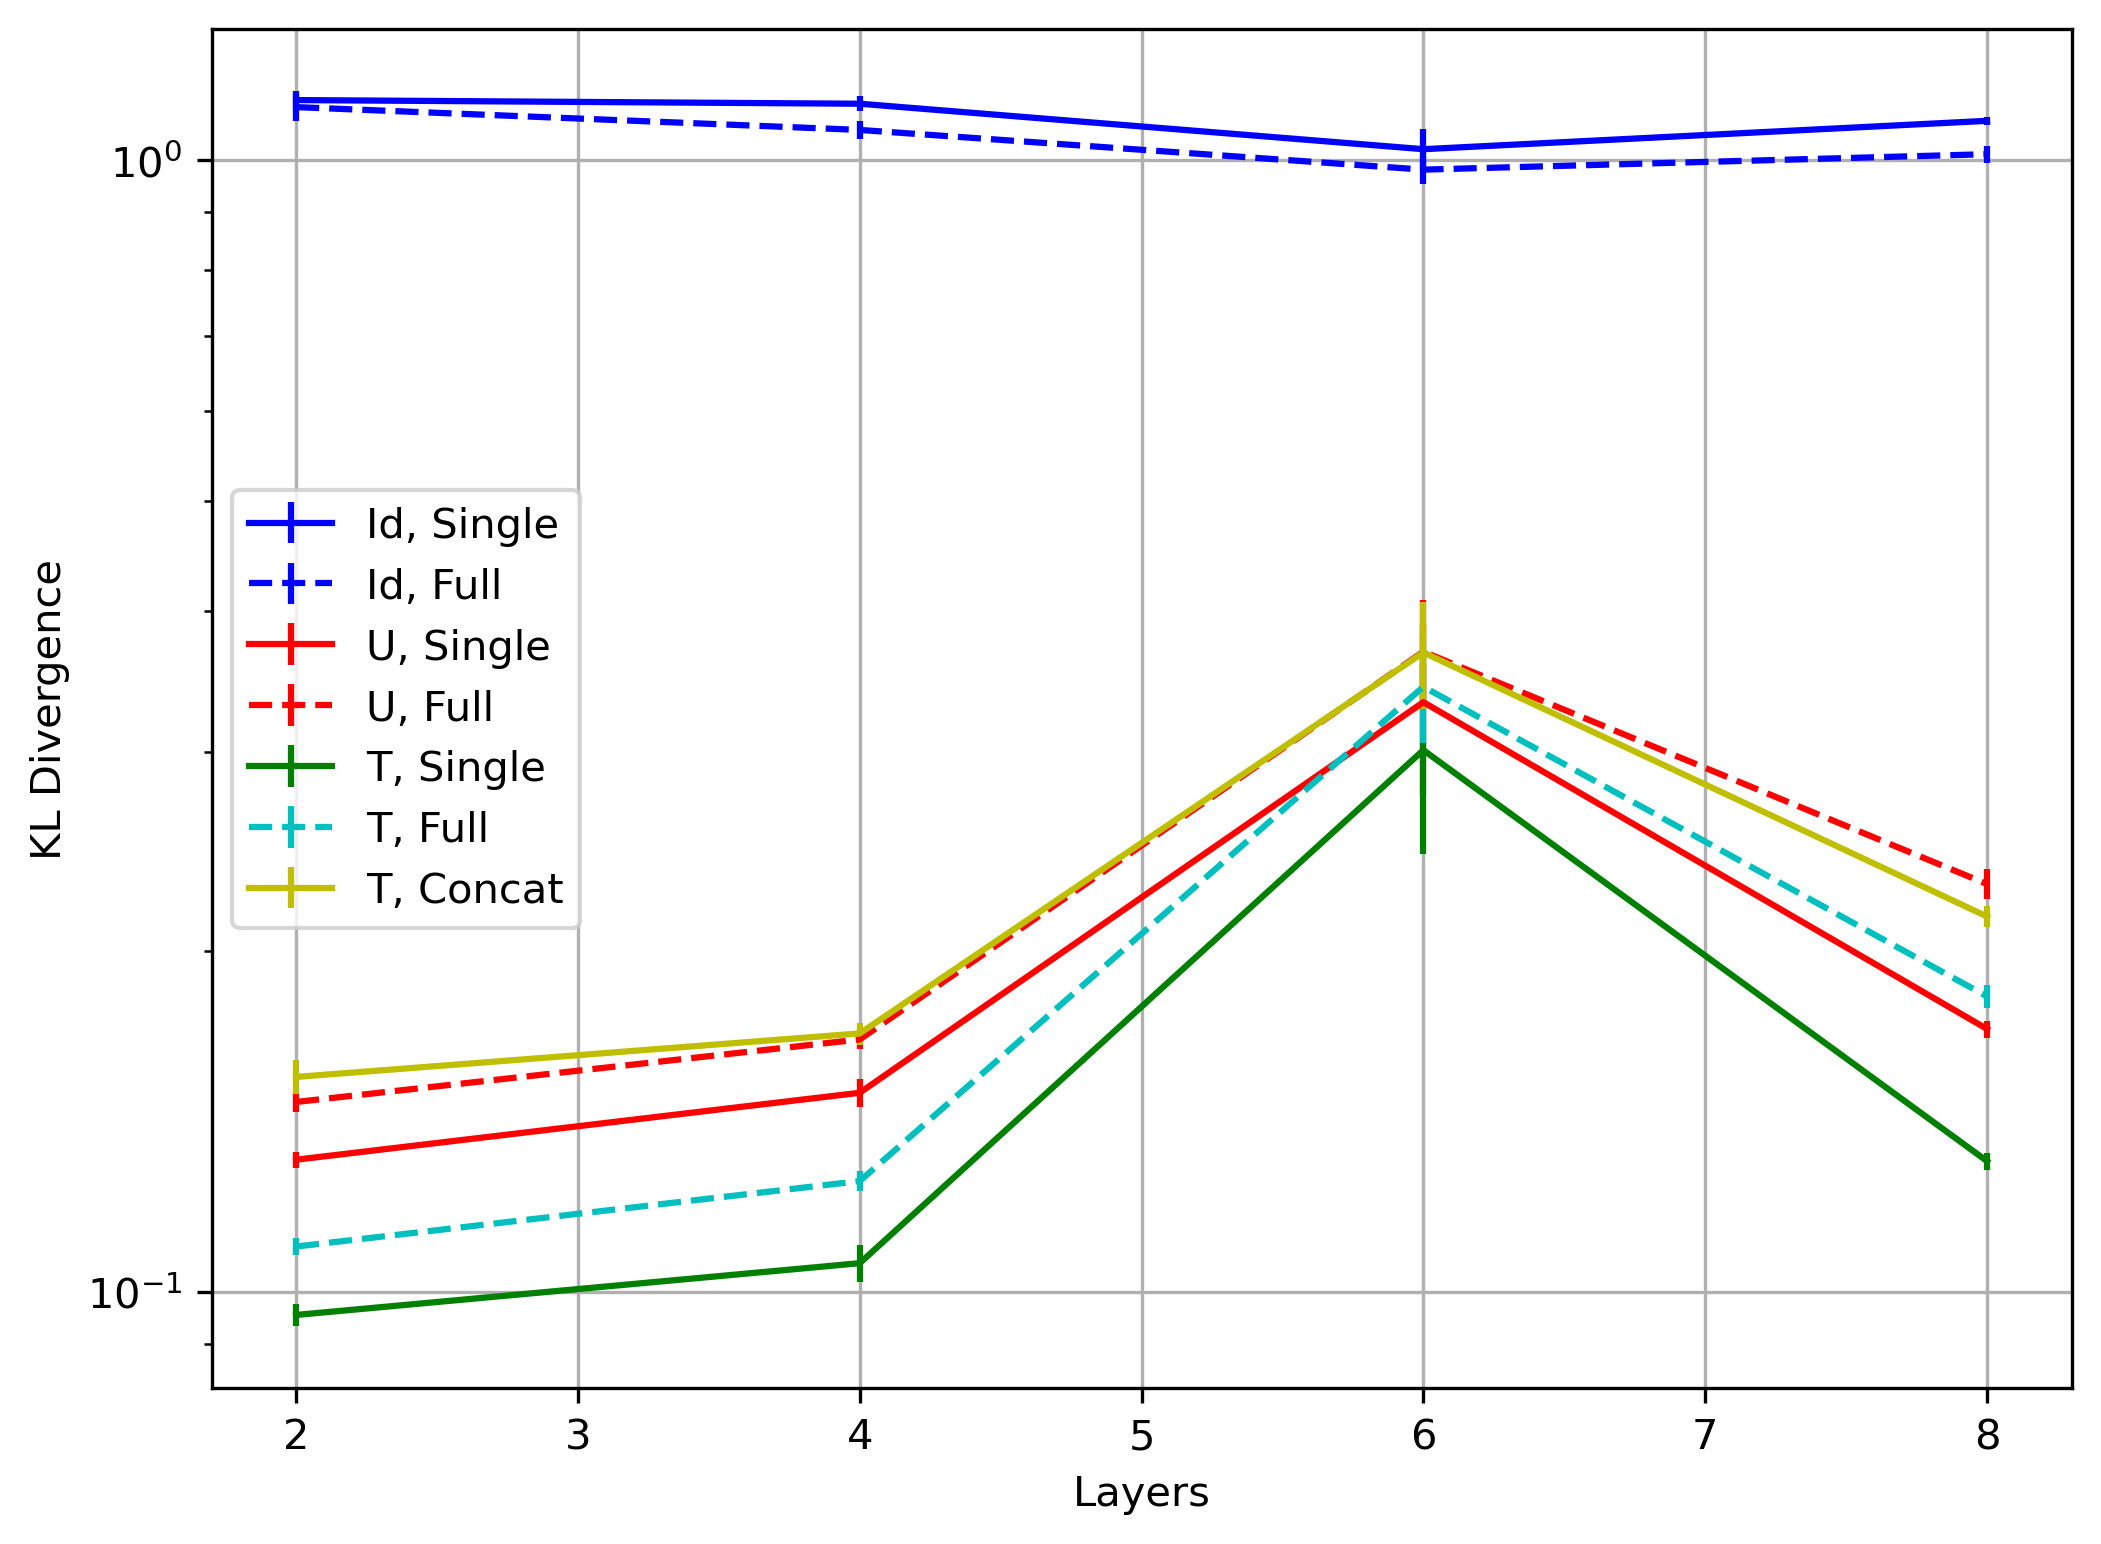

In [27]:
x = [2, 4, 6, 8]
fig = plt.figure(figsize=(8,6), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, mean_list[:,0], yerr = std_list[:,0]/np.sqrt(20), fmt = "b-")
plt.errorbar(x, mean_list[:,1], yerr = std_list[:,1]/np.sqrt(10), fmt = "b--")
plt.errorbar(x, mean_list[:,2], yerr = std_list[:,2]/np.sqrt(20), fmt = "r-")
plt.errorbar(x, mean_list[:,3], yerr = std_list[:,3]/np.sqrt(10), fmt = "r--")
plt.errorbar(x, mean_list[:,4], yerr = std_list[:,4]/np.sqrt(20), fmt = "g-")
plt.errorbar(x, mean_list[:,5], yerr = std_list[:,5]/np.sqrt(10), fmt = "c--")
plt.errorbar(x, mean_list[:,6], yerr = std_list[:,6]/np.sqrt(10), fmt = "y")
plt.legend(["Id, Single", "Id, Full", "U, Single", "U, Full", "T, Single", "T, Full", "T, Concat"])
plt.yscale("log")
plt.xlabel("Layers")
plt.ylabel("KL Divergence")
plt.grid()
plt.show()

In [30]:
model_list1 = loader("data/" + "belem_concatenate_2layer_fitted.model")
model_list2 = loader("data/" + "belem_concatenate_4layer_fitted.model")
model_list3 = loader("data/" + "belem_concatenate_6layer_fitted.model")
model_list4 = loader("data/" + "belem_concatenate_8layer_fitted.model")

In [41]:
for i in range(10):
    model1 = model_list1[3*i]
    model2 = model_list1[3*i+1]
    model3 = model_list1[3*i+2]
    
    super_op1 = reshuffle(model1.channel.choi)
    super_op2 = reshuffle(model2.channel.choi)
    super_op3 = reshuffle(model3.channel.choi)
    
    

In [42]:
choi1 = choi1.numpy().flatten()
choi2 = choi2.numpy().flatten()
choi3 = choi3.numpy().flatten()

In [44]:
#write choi matrices to txt files
np.savetxt("choi_6layer_1.txt", choi1, fmt='%f')
np.savetxt("choi_6layer_2.txt", choi2, fmt='%f')
np.savetxt("choi_12layer.txt", choi3, fmt='%f')